#  Amazon S3를 사용한 솔루션 개발
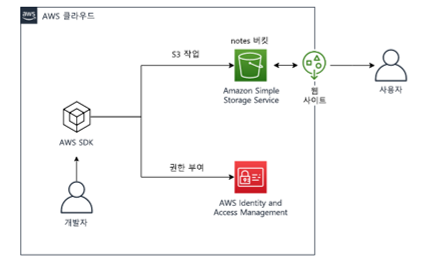
- AWS SDK 및 AWS CLI를 사용하여 프로그래밍 방식으로 Amazon S3와 상호 작용합니다
- waiter를 사용하여 버킷을 생성하고 서비스 예외 코드를 확인합니다. 
- 메타데이터가 첨부된 Amazon S3 객체를 업로드하는 데 필요한 요청을 빌드합니다.
- 버킷에서 객체를 다운로드하는 요청을 빌드하고, 데이터를 처리하고, 객체를 버킷에 다시 업로드합니다.
- AWS CLI를 사용하여 웹 사이트를 호스트하고 소스 파일을 동기화하도록 버킷을 구성합니다.

In [1]:
!pip install boto3

You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


##  1. S3 버킷 생성 : create-bucket.py

- config.ini 파일의 bucket_name 수정(Amazon S3 버킷의 전역적으로 고유한 이름을 생성)
-  예: bucket_name=notes-bucket-iii-00000

In [6]:
import boto3, botocore, configparser, json

In [1]:
def verifyBucketName(s3Client, bucket):
    try:
        ## Start TODO 2: enter a command that will check if a bucket already exists in AWS
        ## with the name built from your ini file input.
        s3Client.head_bucket(Bucket=bucket)

        # If the previous command is successful, the bucket is already in your account.
        raise SystemExit('This bucket has already been created in your account, exiting because there is nothing further to do!')
    except botocore.exceptions.ClientError as e:
        error_code = int(e.response['Error']['Code'])
        if error_code == 404:
          ## If you receive a 404 error code, a bucket with that name
          ##  does not exist anywhere in AWS.
          print('Existing Bucket Not Found, please proceed')
        if error_code == 403:
          ## If you receive a 403 error code, a bucket exists with that
          ## in another AWS account.
          raise SystemExit('This bucket has already owned by another AWS Account, change the suffix and try a new name!')

In [2]:
def createBucket(s3Client, name):
    session = boto3.session.Session()

    # Obtain the region from the boto3 session
    current_region = session.region_name
    print('\nCreating ' + name + ' in ' + current_region)

    # Start TODO 3: Create a new bucket in the users current region 
    # and return the response in a response variable.
    if current_region == 'us-east-1':
        response = s3Client.create_bucket(Bucket=name)
    else:
        response = s3Client.create_bucket(
          Bucket=name,
          CreateBucketConfiguration={
            'LocationConstraint': current_region
          })

In [3]:
def verifyBucket(s3Client, bucket):
    ## Start TODO 4: Complete the function so that it will 
    ## pause and only proceed after the bucket exists.
    waiter = s3Client.get_waiter('bucket_exists')
    waiter.wait(Bucket=bucket)
    print('The bucket:' + bucket + ' is now available.')

In [8]:
## Utility methods
def readConfig():
    config = configparser.ConfigParser()
    config.read('./config.ini')
    
    return config['S3']

In [10]:
s3Client = boto3.client('s3')

config = readConfig()
bucket_name = config['bucket_name']

#### Verify that the bucket exists. 
verifyBucketName(s3Client, bucket_name)
print(bucket_name)

#### Create the notes-bucket-
createBucket(s3Client, bucket_name)

##Pause until the the bucket is in the account
verifyBucket(s3Client, bucket_name)

SystemExit: This bucket has already been created in your account, exiting because there is nothing further to do!

c:\python38\lib\site-packages\IPython\core\interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 2. Amazon S3에 객체 업로드 : create-object.py

In [ ]:
import boto3, botocore, configparser

In [15]:
def uploadObject(s3Client, bucket, name, key, contentType, metadata={}):
    ## create a object by transferring the file to the S3 bucket, 
    ## set the contentType of the file and add any metadata passed to this function.
    response = s3Client.upload_file(
            Bucket=bucket, 
            Key=key,
            Filename=name,
            ExtraArgs={
                'ContentType': contentType,
                'Metadata': metadata
                }
        )

    return "Finished creating object\n"

In [16]:
s3Client = boto3.client('s3')

config = readConfig()

bucket_name = config['bucket_name']
source_file_name = config["object_name"] + config['source_file_extension']
key_name = config['key_name']+ config['source_file_extension']
contentType = config['source_content_type']
metaData_key = config['metaData_key']
metaData_value = config['metaData_value']

#### Create object in the s3 bucket
print(uploadObject(s3Client, bucket_name, source_file_name, key_name, contentType, {metaData_key: metaData_value}))

Finished creating object



##  3. Amazon S3에 저장된 객체의 데이터 처리 : convert-csv-to-json.py

In [18]:
import boto3, botocore, json, csv, io, configparser

In [19]:
def getCSVFile(s3Client, bucket, key):
    bytes_buffer = io.BytesIO()
    
    ## Download the file contents to the 
    ## bytes_buffer object so that it can be decoded to a string.
    s3Client.download_fileobj(
      Bucket=bucket, 
      Key=key, 
      Fileobj=bytes_buffer)

    byte_value = bytes_buffer.getvalue()
    return byte_value.decode('utf-8')

In [20]:
def convertToJSON(input):
    jsonList = []
    keys = []
    
    csvReader = csv.reader(input.split('\n'), delimiter=",")

    for i, row in enumerate(csvReader):
        if i == 0:
            keys = row
        else:
            obj = {}
            for x, val in enumerate(keys):
                obj[val] = row[x]
            jsonList.append(obj)
    return json.dumps(jsonList, indent=4)

In [23]:
def createObject(s3Client, bucket, key, data, contentType, metadata={}):
    ## Create an S3 object with the converted data
    s3Client.put_object(
        Bucket=bucket, 
        Key=key,
        Body=data,
        ContentType=contentType,
        Metadata=metadata
    )
    return 'Successfully Created Object\n'

In [25]:
client = boto3.client('s3')

config = readConfig()

bucket_name = config['bucket_name']
source_file_name = config['object_name'] + config['source_file_extension']
key_name = config['key_name']+ config['source_file_extension']
processed_file_name = config['key_name'] + config['processed_file_extension']
contentType = config['processed_content_type']
metaData_key = config['metaData_key']
metaData_value = config['metaData_value']

#### Get the object from S3
csvStr = getCSVFile(s3Client, bucket_name, key_name)

## Convert the object to the new format
jsonStr = convertToJSON(csvStr)

## Uploaded the converted object to S3
createObject(s3Client, bucket_name, processed_file_name, jsonStr, contentType, {metaData_key: metaData_value})

'Successfully Created Object\n'

## 4. AWS CLI를 사용하여 S3 버킷에서 정적 웹 사이트 호스팅 구성

-  버킷 이름이 포함된 변수를 생성  
```
mybucket=$(aws s3api list-buckets --output text --query 'Buckets[?contains(Name, `notes-bucket`) ==  `true`].Name')
```

- html 폴더의 파일을 버킷과 동기화  
```
aws s3 sync ~/html/. s3://$mybucket/
```

- Amazon S3 웹 사이트 호스팅을 활성화  
```
aws s3api put-bucket-website --bucket $mybucket --website-configuration file://~/website.json
```

- 버킷 이름을 교체
```
sed -i "s/\[BUCKET\]/$mybucket/g" ~/policy.json
```
```
cat ~/policy.json
```

- 버킷 정책 적용  
```
aws s3api put-bucket-policy --bucket $mybucket --policy file://~/policy.json
```

- 리전 값 변수 설정   
```
region=ap-northeast-2
```
또는  
```
region=$(curl http://169.254.169.254/latest/meta-data/placement/region -s)
```

```
http://$mybucket.s3-website-$region.amazonaws.com  접속
```
```
http://notes-bucket-danny-1214.s3-website.ap-northeast-2.amazonaws.com 접속  
```